In [70]:
import pandas as pd
import numpy as np
import xgboost as xgb

## Reading training data and test data

In [71]:
#def loaddata(filename, nrows=None):
#    types = {
#        'id':'int64',
#        'item_nbr':'int16',
#        'unit_sales':'float32',
#        'onpromotion':bool
#    }
#    data = pd.read_csv()

In [73]:
def ToWeight(weight):
    w = np.sum(weight)
    return w

def nwrmsle_xg(yhat, y, weight):
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(weight)
    nwrmsle = np.sqrt(np.sum(weight * (np.log1p(y_hat)) - np.log1p(y)) / w)
    return "nwrmsle", nwrmsle

In [74]:
df_train = pd.read_csv('database/train.csv', low_memory=False, parse_dates=['date'],
                   date_parser = lambda dt:pd.to_datetime(dt, format='%Y-%m-%d'),skiprows=range(1, 124035460),
                   converters={'unit_sales': lambda u: float(u) if float(u) > 0 else 0})
df_test = pd.read_csv('database/test.csv',low_memory=False, parse_dates=['date'], 
                   date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

In [8]:
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,124035459,2017-08-02,1,96995,1.0,False
1,124035460,2017-08-02,1,103520,1.0,False
2,124035461,2017-08-02,1,103665,2.0,False
3,124035462,2017-08-02,1,105574,8.0,False
4,124035463,2017-08-02,1,105575,8.0,False


In [9]:
df_test.head()

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False


In [75]:
len(df_train)

1461581

In [7]:
#df_train.loc[df_train['unit_sales'] <= 0]

In [8]:
#df_train = df_train.loc[df_train['unit_sales'] > 0]

In [76]:
df_train['Set'] = 1
df_test['Set'] = 0

In [77]:
frames = [df_train, df_test]
df = pd.concat(frames)

In [78]:
features_y = ['SalesLog']

In [79]:
tmp = df['unit_sales'].unique()
tmp

array([    1.   ,     2.   ,     8.   ,     5.   ,     3.   ,    14.   ,     6.   ,     7.   ,
           4.   ,     9.   ,    18.   ,    10.   ,    21.   ,     8.406,    30.   ,    11.   ,
          12.   ,     5.874,    25.   ,    27.   ,    16.   ,     3.937,    17.   ,    13.   ,
          23.   ,    19.   ,    34.   ,    22.186,    20.   ,    62.   ,    47.   ,    33.   ,
          22.   ,    32.   ,     5.08 ,     2.893,     2.377,     2.635,    15.025,    28.127,
           5.858,     5.098,     3.392,     6.847,     8.683,     0.742,     9.253,     1.884,
           2.811,     2.73 ,    42.56 ,     3.193,     1.986,     1.474,     1.672,     6.976,
           0.63 ,     4.338,     1.467,     3.945,     2.199,     5.48 ,     4.631,    15.   ,
           0.264,     0.75 ,     7.092,     9.932,     9.216,     7.221,    22.35 ,     5.849,
           1.314,     4.734,     3.337,     4.569,     3.528,     0.738,    28.   ,    26.   ,
           2.849,     6.79 ,    14.008,    17.568,

In [80]:
df.loc[df['Set']==1, 'SalesLog'] = np.log1p(df.loc[df['Set'] == 1]['unit_sales'])

In [86]:
var_name = 'date'
df[var_name + 'Day'] = pd.Index(df[var_name]).day
df[var_name + 'Week'] = pd.Index(df[var_name]).week
df[var_name + 'Month'] = pd.Index(df[var_name]).month
df[var_name + 'Year'] = pd.Index(df[var_name]).year
df[var_name + 'DayOfYear'] = pd.Index(df[var_name]).dayofyear
df[var_name + 'DayOfWeek'] = pd.Index(df[var_name]).dayofweek

df[var_name + 'Day'] = df[var_name + 'Day'].fillna(0)
df[var_name + 'Week'] = df[var_name + 'Week'].fillna(0)
df[var_name + 'Month'] = df[var_name + 'Month'].fillna(0)
df[var_name + 'Year'] = df[var_name + 'Year'].fillna(0)
df[var_name + 'DayOfYear'] = df[var_name + 'DayOfYear'].fillna(0)
df[var_name + 'DayOfWeek'] = df[var_name + 'DayOfWeek'].fillna(0)

In [87]:
features_x = []

In [88]:
features_x.append(var_name + 'Day')
features_x.append(var_name + 'Week')
features_x.append(var_name + 'Month')
features_x.append(var_name + 'Year')
features_x.append(var_name + 'DayOfYear')
features_x.append(var_name + 'DayOfWeek')

In [89]:
features_x

['dateDay',
 'dateWeek',
 'dateMonth',
 'dateYear',
 'dateDayOfYear',
 'dateDayOfWeek']

In [90]:
df['DateInt'] = df['date'].astype(np.int64)

In [91]:
#df.head()

## Setting seed

In [92]:
seed = 42

In [25]:
df.head()

,Set,date,id,item_nbr,onpromotion,store_nbr,unit_sales,SalesLog,dateDay,dateWeek,dateMonth,dateYear,dateDayOfYear,dateDayOfWeek,DateInt
0,1,2017-08-02,124035459,96995,False,1,1.0,0.693147,2,31,8,2017,214,2,1501632000000000000
1,1,2017-08-02,124035460,103520,False,1,1.0,0.693147,2,31,8,2017,214,2,1501632000000000000
2,1,2017-08-02,124035461,103665,False,1,2.0,1.098612,2,31,8,2017,214,2,1501632000000000000
3,1,2017-08-02,124035462,105574,False,1,8.0,2.197225,2,31,8,2017,214,2,1501632000000000000
4,1,2017-08-02,124035463,105575,False,1,8.0,2.197225,2,31,8,2017,214,2,1501632000000000000


## Reading oil data, and fill the empty data to the next day

In [93]:
df_oil = pd.read_csv('database/oil.csv',parse_dates=['date'],
                     date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

In [94]:
#df_oil.loc[df_oil['dcoilwtico'].isnull()]

In [95]:
def FillOilNan(window_size, lenoil, oilprice):
    mean_list = []
    for everyday in null_day:
        backward_index = everyday - window_size
        forward_index = everyday + window_size
        price_list = []
        if backward_index < 0:
            backward_index = 0
        if forward_index > lenoil:
            forward_index = lenoil - 1
        neighbor_data = oilprice[backward_index : forward_index]
        for each in neighbor_data:
            if each > 0:
                price_list.append(each)
        mean_list.append(np.mean(price_list))
    
    return mean_list    

In [96]:
null_day = np.array(df_oil.loc[df_oil['dcoilwtico'].isnull()].index)
price = np.array(df_oil['dcoilwtico'])
mean_price = FillOilNan(2,len(df_oil),price)
df_oil['dcoilwtico'][np.isnan(df_oil['dcoilwtico'])] = mean_price

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### merge the oil data to the frame

In [97]:
df = pd.merge(df, df_oil, how='left', on=['date'])

In [34]:
df.tail()

,Set,date,id,item_nbr,onpromotion,store_nbr,unit_sales,SalesLog,dateDay,dateWeek,dateMonth,dateYear,dateDayOfYear,dateDayOfWeek,DateInt,dcoilwtico
4832040,0,2017-08-31,128867499,2132163,False,54,NaN,NaN,31,35,8,2017,243,3,1504137600000000000,47.26
4832041,0,2017-08-31,128867500,2132318,False,54,NaN,NaN,31,35,8,2017,243,3,1504137600000000000,47.26
4832042,0,2017-08-31,128867501,2132945,False,54,NaN,NaN,31,35,8,2017,243,3,1504137600000000000,47.26
4832043,0,2017-08-31,128867502,2132957,False,54,NaN,NaN,31,35,8,2017,243,3,1504137600000000000,47.26
4832044,0,2017-08-31,128867503,2134244,False,54,NaN,NaN,31,35,8,2017,243,3,1504137600000000000,47.26


In [98]:
features_x.append('dcoilwtico')

In [99]:
features_x

['dateDay',
 'dateWeek',
 'dateMonth',
 'dateYear',
 'dateDayOfYear',
 'dateDayOfWeek',
 'dcoilwtico']

## Reading stores' data

In [100]:
df_store = pd.read_csv('database/stores.csv')

In [101]:
df_store['city_nbr'] = df_store['city'].astype('category').cat.codes
df_store['state_nbr'] = df_store['state'].astype('category').cat.codes
df_store['type_nbr']  = df_store['type'].astype('category').cat.codes

In [102]:
df = pd.merge(df, df_store, how='left',on=['store_nbr'])

In [103]:
store_feature = ['city_nbr', 'state_nbr', 'type_nbr', 'cluster']

In [104]:
features_x.extend(store_feature)
features_x

['dateDay',
 'dateWeek',
 'dateMonth',
 'dateYear',
 'dateDayOfYear',
 'dateDayOfWeek',
 'dcoilwtico',
 'city_nbr',
 'state_nbr',
 'type_nbr',
 'cluster']

In [105]:
#df.head()

## Reading items' data

In [106]:
df_item = pd.read_csv('database/items.csv')
#df_item

In [107]:
df_item['weight'] = np.array(df_item['perishable']) * 0.25 + 1.0

In [108]:
df_item['family_nbr'] = df_item['family'].astype('category').cat.codes

In [109]:
#df_item.head()

In [110]:
df = pd.merge(df, df_item, how='left', on=['item_nbr'])

In [111]:
item_feature = ['family_nbr', 'weight', 'class']
features_x.extend(item_feature)

In [112]:
len(features_x)

14

## Reading transactions data

In [113]:
df_transaction = pd.read_csv('database/transactions.csv', parse_dates=['date'],
                             date_parser= lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'))

In [114]:
#df_transaction.head()

In [115]:
df = pd.merge(df, df_transaction, how='left', on=['date', 'store_nbr'])

In [116]:
transaction_feature = ['transactions']
features_x.extend(transaction_feature)

In [117]:
len(features_x)

15

In [118]:
#df.head()

## Reading holiday_events

In [119]:
df_holiday = pd.read_csv('database/holidays_events.csv', parse_dates=['date'], 
                         date_parser= lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'))

In [120]:
#df_holiday.head()

In [121]:
df_holiday['locale_nbr'] = df_holiday['locale'].astype('category').cat.codes

In [122]:
df_holiday['locale_nbr'].unique()

array([0, 2, 1], dtype=int64)

In [123]:
df = pd.merge(df, df_holiday, how='left', on=['date'])

In [124]:
holiday_feature = ['locale_nbr']
features_x.extend(holiday_feature)

In [53]:
#df_store

## 可视化检查数据

In [51]:
import matplotlib.pyplot as plt
import pylab
import csv
import datetime
import math
import re
import time
import random
import os

from pandas.tseries.offsets import *
from operator import *

from sklearn.cross_validation import train_test_split

%matplotlib inline

# plt.style.use('ggplot') # Good looking plots

np.set_printoptions(precision=4, threshold=10000, linewidth=100, edgeitems=999, suppress=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 100)
pd.set_option('expand_frame_repr', False)
pd.set_option('precision', 6)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [61]:
list_stores_to_check = np.array(df_store['store_nbr'])
#list_stores_to_check = [1]

In [62]:
list_stores_to_check

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52, 53, 54], dtype=int64)

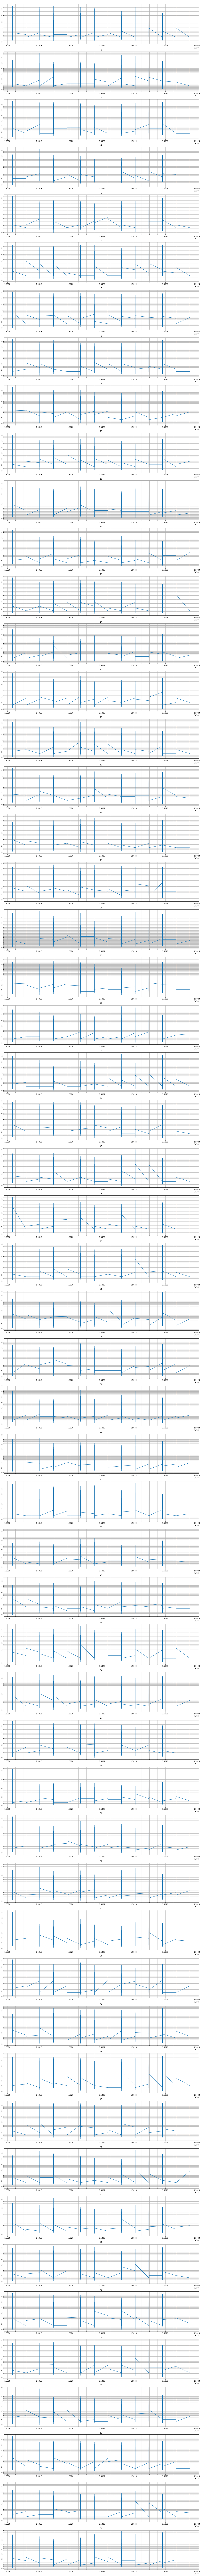

In [65]:
plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['store_nbr'] == stor)  ]
    y1 = df.loc[(df['Set'] == 1) & (df['store_nbr'] == stor)  ]['SalesLog']

    Xt = df.loc[(df['store_nbr'] == stor)]
    
    plt.subplot(len(list_stores_to_check),1,j)
    plt.plot(X1['DateInt'], y1, '-')
    plt.minorticks_on()
    plt.grid(True, which='both')
    plt.title(i)
    j += 1

In [58]:
df.loc[(df['store_nbr'] == 1) & (df['Set'] == 1)&(df['item_nbr']==96995)][['date','DateInt','item_nbr','unit_sales']].iloc[:1000]

,date,DateInt,item_nbr,unit_sales
0,2017-08-02,1501632000000000000,96995,1.0
107407,2017-08-03,1501718400000000000,96995,2.0
424709,2017-08-06,1501977600000000000,96995,2.0
535551,2017-08-07,1502064000000000000,96995,2.0
841572,2017-08-10,1502323200000000000,96995,1.0


In [75]:
df.loc[df['Set']== 1].tail()

,Set,date,id,item_nbr,onpromotion,store_nbr,unit_sales,SalesLog,dateDay,dateWeek,dateMonth,dateYear,dateDayOfYear,dateDayOfWeek,DateInt,dcoilwtico,city,state,type_x,cluster,city_nbr,state_nbr,type_nbr,family,class,perishable,weight,family_nbr,transactions,type_y,locale,locale_name,description,transferred,locale_nbr
999925,1,2013-01-26,999995,716250,NaN,43,6.0,1.945910,26,4,1,2013,26,5,1359158400000000000,NaN,Esmeraldas,Esmeraldas,E,10,6,5,4,BEVERAGES,1120,0,1.00,3,1147.0,NaN,NaN,NaN,NaN,NaN,NaN
999926,1,2013-01-26,999996,723184,NaN,43,2.0,1.098612,26,4,1,2013,26,5,1359158400000000000,NaN,Esmeraldas,Esmeraldas,E,10,6,5,4,DAIRY,2116,1,1.25,8,1147.0,NaN,NaN,NaN,NaN,NaN,NaN
999927,1,2013-01-26,999997,724498,NaN,43,3.0,1.386294,26,4,1,2013,26,5,1359158400000000000,NaN,Esmeraldas,Esmeraldas,E,10,6,5,4,GROCERY I,1028,0,1.00,12,1147.0,NaN,NaN,NaN,NaN,NaN,NaN
999928,1,2013-01-26,999998,730258,NaN,43,2.0,1.098612,26,4,1,2013,26,5,1359158400000000000,NaN,Esmeraldas,Esmeraldas,E,10,6,5,4,BEVERAGES,1122,0,1.00,3,1147.0,NaN,NaN,NaN,NaN,NaN,NaN
999929,1,2013-01-26,999999,730259,NaN,43,3.0,1.386294,26,4,1,2013,26,5,1359158400000000000,NaN,Esmeraldas,Esmeraldas,E,10,6,5,4,BEVERAGES,1122,0,1.00,3,1147.0,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
df_train.tail()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,Set
999995,999995,2013-01-26,43,716250,6.0,NaN,1
999996,999996,2013-01-26,43,723184,2.0,NaN,1
999997,999997,2013-01-26,43,724498,3.0,NaN,1
999998,999998,2013-01-26,43,730258,2.0,NaN,1
999999,999999,2013-01-26,43,730259,3.0,NaN,1


In [ ]:
df_test.head()

## 将训练数据中的空值进行替换

In [125]:
df['onpromotion'].astype(float)
df['onpromotion'] = df['onpromotion'].fillna(0)

In [126]:
features_x.append('onpromotion')

In [127]:
add_feature = ['item_nbr', 'store_nbr']

In [128]:
features_x.extend(add_feature)

In [129]:
len(features_x)

19

In [130]:
#features_x.append('Set')
#features_x.append('SalesLog')

In [131]:
features_x

['dateDay',
 'dateWeek',
 'dateMonth',
 'dateYear',
 'dateDayOfYear',
 'dateDayOfWeek',
 'dcoilwtico',
 'city_nbr',
 'state_nbr',
 'type_nbr',
 'cluster',
 'family_nbr',
 'weight',
 'class',
 'transactions',
 'locale_nbr',
 'onpromotion',
 'item_nbr',
 'store_nbr']

## Extract all useful data

### 将locale_nbr为Nan的设置为3，表示工作日

In [132]:
df['locale_nbr'] = df['locale_nbr'].fillna(3.0)

In [133]:
df['transactions'] = df['transactions'].fillna(0)

## Split the data

In [134]:
from sklearn.cross_validation import train_test_split

In [135]:
features_x

['dateDay',
 'dateWeek',
 'dateMonth',
 'dateYear',
 'dateDayOfYear',
 'dateDayOfWeek',
 'dcoilwtico',
 'city_nbr',
 'state_nbr',
 'type_nbr',
 'cluster',
 'family_nbr',
 'weight',
 'class',
 'transactions',
 'locale_nbr',
 'onpromotion',
 'item_nbr',
 'store_nbr']

In [136]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[df['Set'] == 1][features_x], 
                                                    df.loc[df['Set'] == 1][features_y], 
                                                   test_size = 0.1, random_state = seed)

## 第二次训练，使用最后面的一百万条数据，并且使用一个类来进行评估

In [137]:
class NWRMSLE:
    def set_weights(self, weights):
        self.weights = weights

    def _NWRMSLE(self, a, p, w):
        a = np.array(a)
        a[a < 0.0]=0.0
        p = np.array(p)
        p[p < 0.0]=0.0
        w = np.array(w)
        weighted_errors = np.dot(np.square(np.log1p(p) - np.log1p(a)), np.transpose(w))
        weights_sum = np.sum(w)
        return math.sqrt(weighted_errors/weights_sum)

    def NWRMSLE_xgb(self, preds, dtrain):
        labels = dtrain.get_label()
        NWRMSLE_score = self._NWRMSLE(labels, preds, self.weights)
        return [('NWRMSLE', NWRMSLE_score)]
    

In [138]:
X_test_weight = X_test['weight']
eval_metric = NWRMSLE()
eval_metric.set_weights(X_test_weight)

In [139]:
del X_train['weight']
del X_test['weight']

In [140]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [143]:
num_round = 20000
evallist = [(dtest, 'test')]

param = {'bst:max_depth':12,
         'bst:eta':0.01,
         'subsample':0.8,
         'colsample_bytree':0.7,
         'silent':1,
         'objective':'reg:linear',
         'nthread':6,
         'eval_metric':'rmse',
         'seed':seed}
plst = param.items()

In [144]:
bst = xgb.train(plst, dtrain, num_round, evallist, feval=eval_metric.NWRMSLE_xgb, verbose_eval=250, early_stopping_rounds=250)

[0]	test-rmse:1.1656	test-NWRMSLE:0.435193
Multiple eval metrics have been passed: 'test-NWRMSLE' will be used for early stopping.

Will train until test-NWRMSLE hasn't improved in 250 rounds.
[250]	test-rmse:0.602986	test-NWRMSLE:0.227574
[500]	test-rmse:0.569478	test-NWRMSLE:0.216999
[750]	test-rmse:0.553762	test-NWRMSLE:0.211986
[1000]	test-rmse:0.543259	test-NWRMSLE:0.208718
[1250]	test-rmse:0.536481	test-NWRMSLE:0.206619
[1500]	test-rmse:0.531837	test-NWRMSLE:0.205179
[1750]	test-rmse:0.527861	test-NWRMSLE:0.203936
[2000]	test-rmse:0.525241	test-NWRMSLE:0.203151
[2250]	test-rmse:0.522949	test-NWRMSLE:0.202472
[2500]	test-rmse:0.521031	test-NWRMSLE:0.201915
[2750]	test-rmse:0.519559	test-NWRMSLE:0.20145
[3000]	test-rmse:0.518402	test-NWRMSLE:0.201128
[3250]	test-rmse:0.517382	test-NWRMSLE:0.200816
[3500]	test-rmse:0.516318	test-NWRMSLE:0.200519
[3750]	test-rmse:0.515489	test-NWRMSLE:0.200275
[4000]	test-rmse:0.514799	test-NWRMSLE:0.200092
[4250]	test-rmse:0.514151	test-NWRMSLE:0.19

## 第一次训练，使用最前面的一百万条数据，并且在DMatrix中设置权重，效果很差

In [54]:
X_train_weight = X_train['weight']
X_test_weight = X_test['weight']

In [55]:
del X_train['weight']
del X_test['weight']

In [56]:
dtrain = xgb.DMatrix(X_train, y_train, weight=X_train_weight)
dtest = xgb.DMatrix(X_test, y_test, weight=X_test_weight)

In [57]:
num_round = 20000
evallist = [(dtrain, 'train'), (dtest, 'test')]

In [58]:
seed

42

In [59]:
param = {'bst:max_depth':12,
         'bst:eta':0.01,
         'subsample':0.8,
         'colsample_bytree':0.7,
         'silent':1,
         'objective':'reg:linear',
         'nthread':6,
         'eval_metric':'rmse',
         'seed':seed}
plst = param.items()

In [60]:
bst = xgb.train(plst, dtrain, num_round, evallist, verbose_eval=250, early_stopping_rounds=1000)

[0]	train-rmse:1.22892	test-rmse:1.23035
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 1000 rounds.
[250]	train-rmse:0.637104	test-rmse:0.637636
[500]	train-rmse:0.615824	test-rmse:0.616808
[750]	train-rmse:0.604484	test-rmse:0.605976
[1000]	train-rmse:0.597537	test-rmse:0.599469
[1250]	train-rmse:0.592401	test-rmse:0.594845
[1500]	train-rmse:0.588678	test-rmse:0.591557
[1750]	train-rmse:0.585695	test-rmse:0.589002
[2000]	train-rmse:0.583243	test-rmse:0.586968
[2250]	train-rmse:0.581233	test-rmse:0.585385
[2500]	train-rmse:0.579251	test-rmse:0.583806
[2750]	train-rmse:0.577384	test-rmse:0.582353
[3000]	train-rmse:0.576201	test-rmse:0.58156
[3250]	train-rmse:0.574909	test-rmse:0.580635
[3500]	train-rmse:0.573875	test-rmse:0.579988
[3750]	train-rmse:0.572783	test-rmse:0.579212
[4000]	train-rmse:0.571708	test-rmse:0.578489
[4250]	train-rmse:0.570749	test-rmse:0.577854
[4500]	train-rmse:0.570007	test-rmse

In [145]:
import pylab
import csv
import datetime
import math
import re
import time
import random
import os
np.set_printoptions(precision=4, threshold=10000, linewidth=100, edgeitems=999, suppress=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 100)
pd.set_option('expand_frame_repr', False)
pd.set_option('precision', 6)
%matplotlib inline

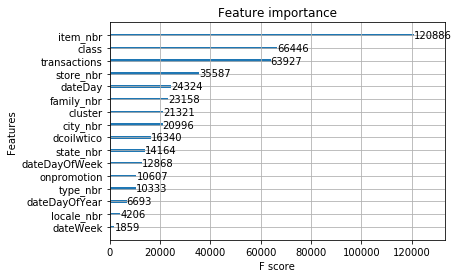

In [146]:
xgb.plot_importance(bst)

## Expore data

In [147]:
X_submit = df.loc[df['Set'] == 0]

In [148]:
X_submit_weight = X_submit['weight']
del X_submit['weight']

In [149]:
features_x.remove('weight')

In [150]:
dsubmit = xgb.DMatrix(X_submit[features_x])

In [151]:
ypred_bst = bst.predict(dsubmit)

In [68]:
df_test.head()

,id,date,store_nbr,item_nbr,onpromotion,Set
0,125497040,2017-08-16,1,96995,False,0
1,125497041,2017-08-16,1,99197,False,0
2,125497042,2017-08-16,1,103501,False,0
3,125497043,2017-08-16,1,103520,False,0
4,125497044,2017-08-16,1,103665,False,0


In [69]:
X_submit.head()

,Set,date,id,item_nbr,onpromotion,store_nbr,unit_sales,SalesLog,dateDay,dateWeek,dateMonth,dateYear,dateDayOfYear,dateDayOfWeek,DateInt,dcoilwtico,city,state,type_x,cluster,city_nbr,state_nbr,type_nbr,family,class,perishable,family_nbr,transactions,type_y,locale,locale_name,description,transferred,locale_nbr
10175512,0,2017-08-16,125497040,96995,0.0,1,NaN,NaN,16,33,8,2017,228,2,1502841600000000000,46.8,Quito,Pichincha,D,13,18,12,3,GROCERY I,1093,0,12,0.0,NaN,NaN,NaN,NaN,NaN,3.0
10175513,0,2017-08-16,125497041,99197,0.0,1,NaN,NaN,16,33,8,2017,228,2,1502841600000000000,46.8,Quito,Pichincha,D,13,18,12,3,GROCERY I,1067,0,12,0.0,NaN,NaN,NaN,NaN,NaN,3.0
10175514,0,2017-08-16,125497042,103501,0.0,1,NaN,NaN,16,33,8,2017,228,2,1502841600000000000,46.8,Quito,Pichincha,D,13,18,12,3,CLEANING,3008,0,7,0.0,NaN,NaN,NaN,NaN,NaN,3.0
10175515,0,2017-08-16,125497043,103520,0.0,1,NaN,NaN,16,33,8,2017,228,2,1502841600000000000,46.8,Quito,Pichincha,D,13,18,12,3,GROCERY I,1028,0,12,0.0,NaN,NaN,NaN,NaN,NaN,3.0
10175516,0,2017-08-16,125497044,103665,0.0,1,NaN,NaN,16,33,8,2017,228,2,1502841600000000000,46.8,Quito,Pichincha,D,13,18,12,3,BREAD/BAKERY,2712,1,5,0.0,NaN,NaN,NaN,NaN,NaN,3.0


In [152]:
df_ypred = X_submit['id'].reset_index()

In [71]:
df_ypred.head()

,index,id
0,10175512,125497040
1,10175513,125497041
2,10175514,125497042
3,10175515,125497043
4,10175516,125497044


In [153]:
del df_ypred['index']
df_ypred['id'] = df_ypred['id'].astype('int')

df_ypred['unit_sales'] = (np.exp(ypred_bst) - 1) * 0.985
df_ypred['unit_sales'] = df_ypred['unit_sales'].apply(lambda dt: dt if dt > 0 else 0)


df_ypred.sort_values('id', inplace=True)
df_ypred[['id', 'unit_sales']].to_csv('submit4.csv', index=False)